In [7]:
# Adapter 
"""The code to translate Argoverse dataset to KITTI dataset format"""

# Argoverse-to-KITTI Adapter

# Author: Yiyang Zhou 
# Email: yiyang.zhou@berkeley.edu
FILE_NAME_LEN = 9
DONT_CARE = 'DontCare'
print('\nLoading files...')

import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
import os
from shutil import copyfile
from argoverse.utils import calibration
import json
import numpy as np
from argoverse.utils.calibration import CameraConfig
from argoverse.utils.cv2_plotting_utils import draw_clipped_line_segment
from argoverse.utils.se3 import SE3
from argoverse.utils.transform import quat2rotmat
import math
import os
from typing import Union
import numpy as np
import pyntcloud
import progressbar
from time import sleep
import cv2
import pygame
import matplotlib.pyplot as plt
import json
from adapter import *


Loading files...


In [16]:

bev_wanted_classes = [
    "BICYCLE",
    "BUS",
    "TRAILER",
    "MOTORCYCLIST",
    "LARGE_VEHICLE",
    "VEHICLE",
    "PEDESTRIAN",
    "BICYCLIST",
]
lidar_idx = 0
data_dir = '/Users/ck/data_local/argo/argoverse-tracking/sample'
argoverse_data = ArgoverseTrackingLoader(data_dir)
from argoverse.map_representation.map_api import ArgoverseMap
argoverse_map = ArgoverseMap()


In [45]:
def get_bev(argoverse_data, argoverse_map, log_index, frame_index, bnds, meter_per_pixel, drivable_save_path,
            wanted_classes, wanted_save_paths, visualize=True):

    # output bev image setting
    bnd_width = bnds[1] - bnds[0]
    bnd_height = bnds[3] - bnds[2]
    img_width = bnd_width / meter_per_pixel
    img_height = bnd_height / meter_per_pixel
    if img_width != 400 or img_height != 400:
        print(img_width, img_height)

    # intput argoverse log and frame setting
    city_name = argoverse_data.city_name
    se3 = argoverse_data.get_pose(frame_index)
    x, y, _ = argoverse_data.get_pose(frame_index).translation
    bnds = bnds + np.array([x, x, y, y])
    polys = argoverse_map.find_local_driveable_areas(bnds, city_name)

    bev_drivable = pygame.Surface([img_height, img_width])
    bev_all = pygame.Surface([img_height, img_width])
    bev_fov = pygame.Surface([img_height, img_width])
    
    ############################## construct the fov mask (1 for bev pixels within camera fov)
    img_width = 1920
    
    # pick 4 points in the image coordinate also with the depths to define the 4 corners of the fov
    # uv_depth, where u is the width of the image, v is height of image, depth is how far that obj is
    fov_corners_uv_depth = np.array([
        [0, 0, 0.01],  # upper left hand corner of the image, at depth 0.01 meter
        [0, 0, 100],  # upper left hand corner of the image, at depth 100 meter
        [img_width - 1, 0, 100],  # upper right hand corner of the image, at depth 100 meter
        [img_width - 1, 0, 0.01],  # upper right hand corner of the image, at depth 0.01 meter
#         [960, 600, 100],
    ])
    calib = argoverse_data.get_calibration('ring_front_center')
    fov_corners_ego = calib.project_image_to_ego(fov_corners_uv_depth)[:, :2]  # discard the z (height)
    
    # in the ego coord, +x is going forward and +y is to the left, but in BEV image
    # we expect +x (increment in rows) is going down and +y is to the right.
    # Therefore, we flip both coordinate
    fov_corners_ego *= -1
    
    # move origin to the center of the image
    fov_corners_ego += np.array(bnd_height // 2, bnd_width)
    
    # now in the coordinate sys of bev pixels
    fov_corners_bev = fov_corners_ego / meter_per_pixel
    
    # draw on the surface
    pygame.draw.polygon(bev_fov, [255, 0, 0], fov_corners_bev)
    
    # ckk
    
    ############################## drawing the drivable regions
    for poly_city in polys[1:]:

        # for some reason, the height dimension of the polygons sometimes might have NaN values
        # we simply replace them by the cloest values to the right
        if has_nan(poly_city):
            poly_city[:, 2] = replace_nan_by_closest(poly_city[:, 2])

        # transform the polygons from the city coordinate to the ego vehicle coordinate
        poly_ego = se3.inverse_transform_point_cloud(poly_city)

        # project to 2d plane, now of shape [n, 2]
        poly_ego_projected = np.array(poly_ego[:, :2])

        # in the ego coord, +x is going forward and +y is to the left, but in BEV image
        # we expect +x (increment in rows) is going down and +y is to the right.
        # Therefore, we flip both coordinate
        poly_ego_projected *= -1

        # move origin to the center of the image
        poly_ego_projected += np.array(bnd_height // 2, bnd_width)

        # map the polygon to pixel coordinate on the image so that we can draw it
        pixels = poly_ego_projected / meter_per_pixel

        # note the color only matters for visualization
        pygame.draw.polygon(bev_drivable, [255, 0, 0], pixels)
        pygame.draw.polygon(bev_all, [255, 0, 0], pixels)
        
    ############################## drawing the objects of each classes

    # get the objects of a frame
    object_records = argoverse_data.get_label_object(frame_index)

    bev_classes = []  # object class name mapped to the surface of that class
    for object_cls in wanted_classes:

        bev = pygame.Surface([img_height, img_width])

        # get 8 corners of each object
        # bboxes_corners is of shape [N, 8, 3] where N is the num of objects and 8 are the 8 corners
        bboxes_corners = np.array([r.as_3d_bbox() for r in object_records if r.label_class == object_cls])

        # in case there were no object of that class, we still generate empty bev image
        if len(bboxes_corners) > 0:

            # determine the top 4 corners
            # from https://argoai.github.io/argoverse-api/argoverse.data_loading.html?highlight=corners#argoverse.data_loading.object_label_record.ObjectLabelRecord.as_3d_bbox,
            # we know the corners are ordered, and corner 0, 1, 5, 4 are the top 4 corners that would generate a polygon (IN THAT ORDER!)
            # we also remove the height dimension (which is the z dimension in xyz)
            corner_indices = 0, 1, 5, 4
            bboxes_4corners = bboxes_corners[:, corner_indices, :2]  # of size [N, 4, 2]

            # in the ego coord, +x is going up and +y is to the left, but in BEV image
            # we expect +x (increment in rows) is going down and +y is to the right.
            # Therefore, we flip both coordinate
            bboxes_4corners *= -1

            # move origin to the center of the image
            bboxes_4corners += np.array(bnd_height // 2, bnd_width)

            # map the polygon to pixel coordinate on the image so that we can draw it
            bboxes_4corners_pixels = bboxes_4corners / meter_per_pixel

            for bbox in bboxes_4corners_pixels:
                # note the color only matters for visualization
                pygame.draw.polygon(bev, [0, 255, 0], bbox)
                pygame.draw.polygon(bev_all, [0, 255, 0], bbox)

        bev_classes.append(bev)
        
    ############################## save to disk if paths are supplied

    # save drivable bev images to paths
    if drivable_save_path:
        # convert the pygame surface to binary array
        img_drivable = pygame.surfarray.array2d(bev_drivable)
        img_drivable[img_drivable != 0] = 1

        # flip 0 and 1 because the polygons
        # were actually given as NON-drivable region
        img_drivable = 1 - img_drivable

        cv2.imwrite(drivable_save_path, img_drivable)

    # save bev images to paths, for all wanted classes
    if wanted_save_paths:

        for bev_cls, cls_save_path in zip(bev_classes, wanted_save_paths):
            # convert the pygame surface to binary array
            img_cls = pygame.surfarray.array2d(bev_cls)
            img_cls[img_cls != 0] = 1

            cv2.imwrite(cls_save_path, img_cls)

    # visualize BEV outputs and camera images, useful when debugging in notebook
    if visualize:
        img = pygame.surfarray.array3d(bev_all)
        plt.figure()
        plt.imshow(img)
        
        img = pygame.surfarray.array3d(bev_fov)
        plt.figure()
        plt.imshow(img)

        import argoverse.visualization.visualization_utils as viz_util
        f, ax = viz_util.make_grid_ring_camera(argoverse_data, frame_index)
        plt.show()


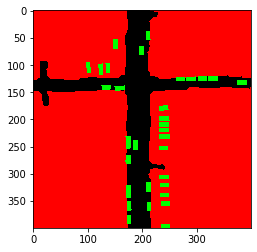

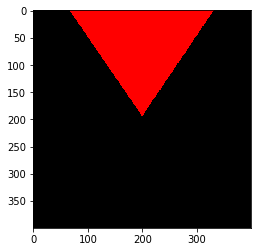

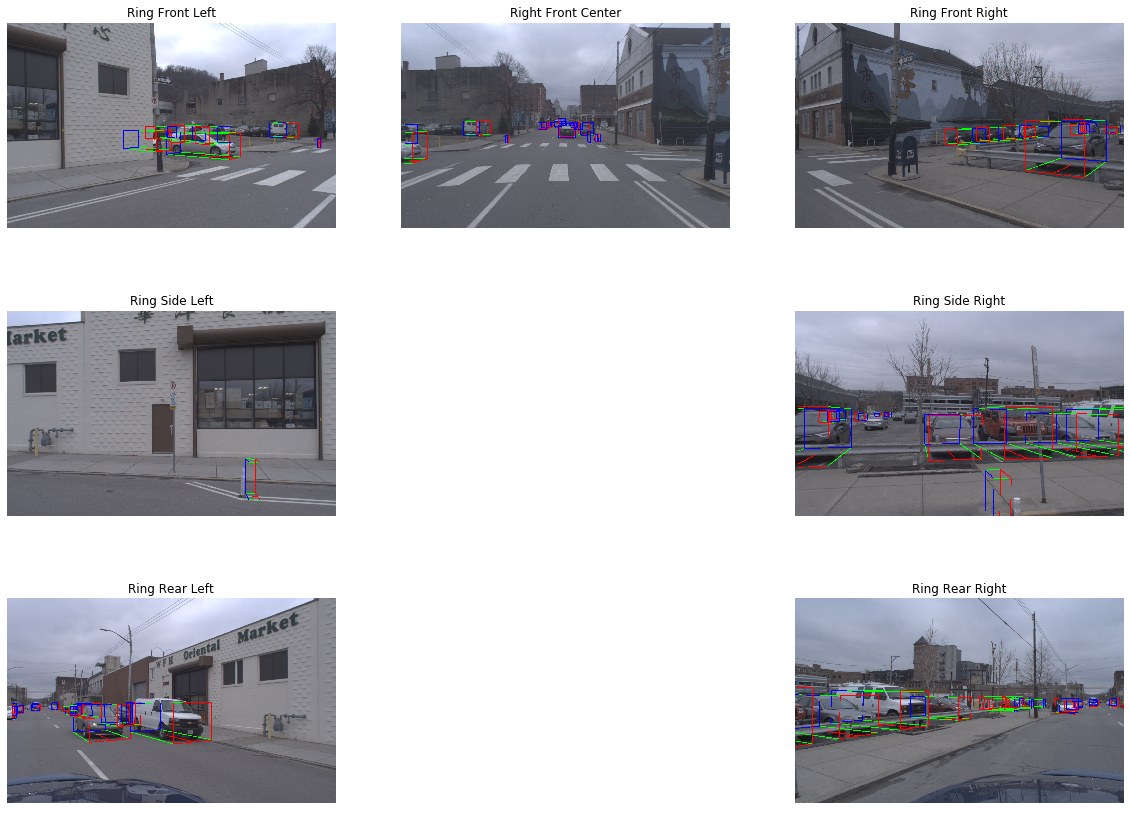

In [46]:
argoverse_map
bnd = 50.0
bev_bnds = np.array([-bnd, +bnd, -bnd, +bnd], dtype=np.float32)
get_bev(argoverse_data, argoverse_map, None, lidar_idx, bev_bnds, 0.25, None, bev_wanted_classes, None, visualize=True)

In [ ]:
be able construct the fov mask
visualize the fov mask
